## Main file, will be copied to neuralnet.py

In [1]:
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm

config = {}
config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
config['batch_size'] = 500  # Number of training samples per batch to be passed to network
config['epochs'] = 50  # Number of epochs to train the model
config['early_stop'] = True  # Implement early stopping or not
config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
config['L2_penalty'] = 0  # Regularization constant
config['momentum'] = True  # Denotes if momentum is to be applied or not
config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
config['learning_rate'] = 0.0007 # Learning rate of gradient descent algorithm

def softmax(x):
  """
  Write the code for softmax activation function that takes in a numpy array and returns a numpy array.
  """
  out_exp = np.exp(x)
  sum_out_exp = out_exp.sum(axis=1)  
  output = out_exp/sum_out_exp[:,None]  
  return output

def sigmoid(x):
  """
  General Sigmoid function
  """
  return 1./(1. + np.exp(-x))

def load_data(fname):
  """
  Write code to read the data and return it as 2 numpy arrays.
  Make sure to convert labels to one hot encoded format.
  """
  f = open(fname, 'rb')
  data = pickle.load(f)
  f.close()
  images, labels = data[:, :-1], data[:, -1]

  labels = labels.astype(np.int)
  onehotlabels = np.zeros((len(labels), labels.max()+1))
  onehotlabels[np.arange(len(labels)), labels] = 1
  return images, onehotlabels


class Activation:
  def __init__(self, activation_type = "sigmoid"):
    self.activation_type = activation_type
    self.x = None # Save the input 'x' for sigmoid or tanh or ReLU to this variable since it will be used later for computing gradients.
  
  def forward_pass(self, a):
    if self.activation_type == "sigmoid":
      return self.sigmoid(a)
    
    elif self.activation_type == "tanh":
      return self.tanh(a)
    
    elif self.activation_type == "ReLU":
      return self.ReLU(a)
  
  def backward_pass(self, delta):
    if self.activation_type == "sigmoid":
      grad = self.grad_sigmoid()
    
    elif self.activation_type == "tanh":
      grad = self.grad_tanh()
    
    elif self.activation_type == "ReLU":
      grad = self.grad_ReLU()
    
    return grad * delta
      
  def sigmoid(self, x):
    """
    Write the code for sigmoid activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = sigmoid(x)
    return output

  def tanh(self, x):
    """
    Write the code for tanh activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = np.tanh(x)
    return output

  def ReLU(self, x):
    """
    Write the code for ReLU activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = np.maximum(x, 0)
    return output

  def grad_sigmoid(self):
    """
    Write the code for gradient through sigmoid activation function that takes in a numpy array and returns a numpy array.
    """
    sigmoid_x = sigmoid(self.x)
    grad = sigmoid_x * (1-sigmoid_x)
    return grad

  def grad_tanh(self):
    """
    Write the code for gradient through tanh activation function that takes in a numpy array and returns a numpy array.
    """
    tanh_x = np.tanh(self.x)
    grad = 1 - (tanh_x * tanh_x)
    return grad

  def grad_ReLU(self):
    """
    Write the code for gradient through ReLU activation function that takes in a numpy array and returns a numpy array.
    """
    grad = np.where(self.x <= 0, 0, 1)
    return grad


class Layer():
  def __init__(self, in_units, out_units):
    np.random.seed(42)
    self.w = np.random.randn(in_units, out_units)  # Weight matrix
    self.b = np.zeros((1, out_units)).astype(np.float32)  # Bias
    self.x = None  # Save the input to forward_pass in this
    self.a = None  # Save the output of forward pass in this (without activation)
    self.d_x = None  # Save the gradient w.r.t x in this (AKA Delta to pass to previous layer = dE/dx)
    self.d_w = None  # Save the gradient w.r.t w in this (AKA dE/dw = Delta received . dx/dw)
    self.d_b = None  # Save the gradient w.r.t b in this (AKA dE/db = Delta received . 1)

  def forward_pass(self, x):
    """
    Write the code for forward pass through a layer. Do not apply activation function here.
    """
    self.x = x
    self.a = x @ self.w + self.b
    return self.a
  
  def backward_pass(self, delta):
    """
    Write the code for backward pass. This takes in gradient from its next layer as input,
    computes gradient for its weights and the delta to pass to its previous layers.
    """

    # This is dE/dw = delta received . dx/dw
    
    def harmadards_sum(X, Y):
      """
        X is [n, dim_x] 
        Y is [n, dim_y]
        Return the sum of all harmadard products between each vector x and y at index i to n
      """
      ans = np.zeros((X.shape[1], Y.shape[1]))
      for i in range(len(X)):
        ans += (X[i][:,None] * Y[i])
      return ans
    
    self.d_w = harmadards_sum(self.x, delta)

    # This is dE/db = delta received . 1
    self.d_b = delta.sum(axis=0)
                
    # This is delta to be passed to previous layer
    self.d_x = delta @ self.w.T
    return self.d_x

      
class Neuralnetwork():
  def __init__(self, config):
    self.layers = []
    self.x = None  # Save the input to forward_pass in this
    self.y = None  # Save the output vector of model in this
    self.targets = None  # Save the targets in forward_pass in this variable
    for i in range(len(config['layer_specs']) - 1):
      self.layers.append( Layer(config['layer_specs'][i], config['layer_specs'][i+1]) )
      
      # Unless it's output unit, add Activation layer on top
      if i < len(config['layer_specs']) - 2:
        self.layers.append(Activation(config['activation']))  
    
  def forward_pass(self, x, targets=None):
    """
    Write the code for forward pass through all layers of the model and return loss and predictions.
    If targets == None, loss should be None. If not, then return the loss computed.
    """
    self.x = x
    self.targets = targets
    
    # Input layer
    out = self.layers[0].forward_pass(x)
    
    # Forward...
    for layer in self.layers[1:]:
      out = layer.forward_pass(out)
      
    # Softmax
    self.y = softmax(out)
        
    # Cross-entropy loss
    if targets is not None:
      return self.loss_func(self.y, targets), self.y
    else:    
      return None, self.y

  def loss_func(self, logits, targets):
    '''
    find cross entropy loss between logits and targets
    '''
    output = -(targets * np.log(logits)).sum()/len(targets)
    return output
    
  def backward_pass(self):
    '''
    implement the backward pass for the whole network. 
    hint - use previously built functions.
    '''
    delta = self.targets - self.y
    
    for layer in reversed(self.layers):
      delta = layer.backward_pass(delta)
    return delta

def trainer(model, X_train, y_train, X_valid, y_valid, config):
  """
  Write the code to train the network. Use values from config to set parameters
  such as L2 penalty, number of epochs, momentum, etc.
  """
  
  BATCH_SIZE = config['batch_size']
  N_EPOCHS = config['epochs']
  LEARNING_RATE = config['learning_rate']
  
  N_BATCHES = len(X_train) // BATCH_SIZE

  EPOCHS_THRESHOLD = config['early_stop_epoch']

  USE_MOMENTUM = config['momentum']
  USE_EARLY_STOP = config['early_stop']
  
  L2_lambda = config['L2_penalty']
  
  GAMMA = 0
  if USE_MOMENTUM:
    GAMMA = config['momentum_gamma']
  
  ACTIVATION = config['activation']
  
  print("-------",
        "Model Config:",
        "\nActivation:", ACTIVATION, 
        "\nN Epoches:", N_EPOCHS, 
        "\nN Batches:",N_BATCHES, 
        "\nBatch size:", BATCH_SIZE, 
        "\nLearning rate:", LEARNING_RATE,
        "\nL2 lambda:", L2_lambda,
        "\nMomentum?", USE_MOMENTUM)
  if USE_MOMENTUM:
    print('Gamma:', GAMMA)

  best_weight_layers = []
  min_loss = float('inf')
  prev_loss = float('inf')
  consecutive_epochs = 0
  
  train_losses = []
  valid_losses = []
  train_accuracies = []
  valid_accuracies = []
  
  for i_epoch in tqdm(range(N_EPOCHS)):
    
    def get_shuffle_inds():
      shuffled_inds = np.arange(len(X_train))
      np.random.shuffle(shuffled_inds)
      return shuffled_inds
    
    shuffled_inds = get_shuffle_inds()
    
    velocities_w = {l: np.zeros_like(l.w) for l in model.layers if type(l) is Layer}
    velocities_b = {l: np.zeros_like(l.b) for l in model.layers if type(l) is Layer}
    
    for i_minibatch in range(0, len(X_train), BATCH_SIZE):
      inds_batch = shuffled_inds[i_minibatch:i_minibatch + BATCH_SIZE]
      X_batch = X_train[inds_batch]
      y_batch = y_train[inds_batch]
      
      loss, _ = model.forward_pass(X_batch, y_batch)
      delta = model.backward_pass()
            
      # Weight updates
      for l in model.layers:
        if type(l) is Layer:
          
          # To prevent confusion on sign when
          # combining with momentum/regularization
          # ------------------------------------
          
          # l.d_w and d_b is actually delta
          delta_w = l.d_w
          delta_b = l.d_b
          
          # To get gradient of loss E to w, negate it
          
          # Complete gradient of loss E with L2 Reg
          # No reg for bias
          # Ref: http://neuralnetworksanddeeplearning.com/chap3.html#eqtn92
          dE_dw = (-delta_w + L2_lambda*l.w) / len(X_batch)
          dE_db = -delta_b / len(X_batch)
          
          # Apply Momentum
          prev_vw = velocities_w[l]
          current_vw = GAMMA*prev_vw + LEARNING_RATE * dE_dw
          
          prev_vb = velocities_b[l]
          current_vb = GAMMA*prev_vb + LEARNING_RATE * dE_db
          
          # Update weights
          l.w -= current_vw
          l.b -= current_vb
          
          # Save velocities
          velocities_w[l] = current_vw
          velocities_b[l] = current_vb

    # RECORD FOR REPORT
    loss_train, _ = model.forward_pass(X_train, y_train)
    loss_valid, _ = model.forward_pass(X_valid, y_valid)    
        
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    
    accuracy_train = test(model, X_train, y_train, config)
    accuracy_valid = test(model, X_valid, y_valid, config)
    
    train_accuracies.append(accuracy_train)
    valid_accuracies.append(accuracy_valid)
    
    print('Epoch:', i_epoch, 
          'loss train:', loss_train, 
          'loss validate:', loss_valid, 
          "Acc train:", accuracy_train,
         'Acc validate:', accuracy_valid)
    
    if USE_EARLY_STOP:      
      if loss_valid < min_loss:
        min_loss = loss_valid
        best_weight_layers = model.layers
      
      if loss_valid > prev_loss:
        consecutive_epochs += 1
        if consecutive_epochs == EPOCHS_THRESHOLD:
          model.layers = best_weight_layers
          print('Stop training as validation loss increases for {} epochs'.format(EPOCHS_THRESHOLD))
          break
      else: 
        consecutive_epochs = 0
      
      prev_loss = loss_valid
  return {
    'train_losses': train_losses, 
    'valid_losses': valid_losses, 
    'train_accuracies': train_accuracies, 
    'valid_accuracies': valid_accuracies
  }
        
      
  
def test(model, X_test, y_test, config):
  """
  Write code to run the model on the data passed as input and return accuracy.
  """
  _, logits = model.forward_pass(X_test)
  predictions = np.argmax(logits, axis=1) # inds that we made predictions (0,1,2,3, ...)
  
  # convert y_test from one-hot to actual target inds
  targets = y_test.nonzero()[1]
  accuracy = (predictions == targets).sum()/len(targets)
  return accuracy

# if __name__ == "__main__":
#   train_data_fname = 'data/MNIST_train.pkl'
#   valid_data_fname = 'data/MNIST_valid.pkl'
#   test_data_fname = 'data/MNIST_test.pkl'
  
#   ### Train the network ###
#   model = Neuralnetwork(config)
#   X_train, y_train = load_data(train_data_fname)
#   X_valid, y_valid = load_data(valid_data_fname)
#   X_test, y_test = load_data(test_data_fname)
#   trainer(model, X_train, y_train, X_valid, y_valid, config)
#   test_acc = test(model, X_test, y_test, config)
#   print("Test Accuracy:", test_acc)

## Default Training

In [ ]:
if __name__ == "__main__":
  train_data_fname = 'data/MNIST_train.pkl'
  valid_data_fname = 'data/MNIST_valid.pkl'
  test_data_fname = 'data/MNIST_test.pkl'
  
  ### Train the network ###
  model = Neuralnetwork(config)
  X_train, y_train = load_data(train_data_fname)
  X_valid, y_valid = load_data(valid_data_fname)
  X_test, y_test = load_data(test_data_fname)
  trainer(model, X_train, y_train, X_valid, y_valid, config)
  test_acc = test(model, X_test, y_test, config)
  print("Test Accuracy:", test_acc)

## b) Check with gradient approximation

In [59]:
train_data_fname = 'data/MNIST_train.pkl'
valid_data_fname = 'data/MNIST_valid.pkl'
test_data_fname = 'data/MNIST_test.pkl'

### Train the network ###
model = Neuralnetwork(config)
X_train, y_train = load_data(train_data_fname)
X_valid, y_valid = load_data(valid_data_fname)
X_test, y_test = load_data(test_data_fname)

### Bias

In [68]:
X_test, y_test = load_data(test_data_fname)

EPSILON = 1e-9

def test_approximation_bias(model, layer_ind, unit_ind, epsilon=1e-2, report_mode=False):
  sample_test = np.random.randint(len(X_test))
  X_sample = X_test[0,:].reshape((1,-1))
  y_sample = y_test[0,:].reshape((1,-1))

  original_w = model.layers[layer_ind].b[0,unit_ind]
  
  # Approximation
  model.layers[layer_ind].b[0,unit_ind] = original_w + epsilon
  w_plus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  model.layers[layer_ind].b[0,unit_ind] = original_w - epsilon
  w_minus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  
  estimated_dE_dw = (w_plus_epsilon_loss - w_minus_epsilon_loss)/(2*epsilon)
  
  # Restore
  model.layers[layer_ind].b[0,unit_ind] = original_w
  
  # Actual BPP gradient
  model.forward_pass(X_sample, y_sample)
  model.backward_pass()
  bpp_dE_dw = -model.layers[layer_ind].d_b[unit_ind]/len(X_sample)
  
  if report_mode:
    print("Estimated:", estimated_dE_dw, "Actual BPP:", bpp_dE_dw, "Abs Diff", abs(estimated_dE_dw - bpp_dE_dw))
  return abs(estimated_dE_dw - bpp_dE_dw), abs(estimated_dE_dw - bpp_dE_dw) <= 9*epsilon**2
  
# BIAS CHECK
checks = []
model = Neuralnetwork(config)
for layer_i in [0, 2]:
  for unit_i in range(model.layers[layer_i].b.shape[1]):
    raw_diff, is_close_enough = test_approximation_bias(model, layer_i, unit_i, 1e-4)
    checks.append(is_close_enough)
    
print("Percent of weight approximation within bounds:", sum(checks)/len(checks))

Percent of weight approximation within bounds: 1.0


In [101]:
model = Neuralnetwork(config)
for ep in [1e-1, 1e-2, 1e-3, 1e-4]:
  print("Epsilon:", ep)
  test_approximation_bias(model, 0, 5, epsilon=ep, report_mode=True)
  print("---------")

Epsilon: 0.1
Estimated: 9.129941247465467e-10 Actual BPP: 9.069444029224897e-10 Abs Diff 6.049721824057006e-12
---------
Epsilon: 0.01
Estimated: 9.070078021977679e-10 Actual BPP: 9.069444029224897e-10 Abs Diff 6.339927527816159e-14
---------
Epsilon: 0.001
Estimated: 9.07718344933528e-10 Actual BPP: 9.069444029224897e-10 Abs Diff 7.739420110382618e-13
---------
Epsilon: 0.0001
Estimated: 9.059419880941277e-10 Actual BPP: 9.069444029224897e-10 Abs Diff 1.0024148283619887e-12
---------


### Weights

In [102]:
X_test, y_test = load_data(test_data_fname)

def test_approximation_weight(model, layer_ind, unit_in, unit_out, epsilon=1e-2, report_mode=False):
  sample_test = np.random.randint(len(X_test))
  X_sample = X_test[sample_test,:].reshape((1,-1))
  y_sample = y_test[sample_test,:].reshape((1,-1))

  original_w = model.layers[layer_ind].w[unit_in, unit_out]
  
  # Approximation
  model.layers[layer_ind].w[unit_in, unit_out] = original_w + epsilon
  w_plus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  model.layers[layer_ind].w[unit_in, unit_out] = original_w - epsilon
  w_minus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  
  estimated_dE_dw = (w_plus_epsilon_loss - w_minus_epsilon_loss)/(2*epsilon)
  
  # Restore
  model.layers[layer_ind].w[unit_in, unit_out] = original_w
  
  # Actual BPP gradient
  model.forward_pass(X_sample, y_sample)
  model.backward_pass()
  bpp_dE_dw = -model.layers[layer_ind].d_w[unit_in, unit_out]/len(X_sample)
  
  if report_mode:
    print("Estimated:", estimated_dE_dw, "Actual BPP:", bpp_dE_dw, "Abs Diff", abs(estimated_dE_dw - bpp_dE_dw))
  return abs(estimated_dE_dw - bpp_dE_dw), abs(estimated_dE_dw - bpp_dE_dw) <= 9*epsilon**2
  
# MASS BIAS CHECK
checks = []
model = Neuralnetwork(config)
for layer_i in tqdm([0, 2]):
  for unit_in in tqdm(range(min(model.layers[layer_i].w.shape[0], 100))):
    for unit_out in range(min(model.layers[layer_i].w.shape[1], 100)):
      raw_diff, is_close_enough = test_approximation_weight(model, layer_i, unit_in, unit_out, 1e-3)
      checks.append(is_close_enough)
    
print("Percent of bias approximation within bounds:", sum(checks)/len(checks))

Percent of bias approximation within bounds: 1.0


In [121]:
model = Neuralnetwork(config)
for ep in [1e-1, 1e-2, 1e-3, 1e-4]:
  print("Epsilon:", ep)
  test_approximation_weight(model, 0, 290, 22, epsilon=ep, report_mode=True)
  print("---------")

Epsilon: 0.1
Estimated: -3.1443283532439636e-08 Actual BPP: -3.123464274458815e-08 Abs Diff 2.0864078785148627e-10
---------
Epsilon: 0.01
Estimated: 0.0010964286848214044 Actual BPP: 0.0010963570128047493 Abs Diff 7.167201665513913e-08
---------
Epsilon: 0.001
Estimated: -0.39929861386056587 Actual BPP: -0.3992984508089363 Abs Diff 1.630516295869633e-07
---------
Epsilon: 0.0001
Estimated: 0.0 Actual BPP: -7.332949006261695e-16 Abs Diff 7.332949006261695e-16
---------


## c) Loss/Accuracy vs epoch

In [2]:
import matplotlib.pyplot as plt

def evaluate_model(config):
  """
    Train model with given config.
    Return train_report that has train/valid losses and accuracies
  """
  train_data_fname = 'data/MNIST_train.pkl'
  valid_data_fname = 'data/MNIST_valid.pkl'
  test_data_fname = 'data/MNIST_test.pkl'
  
  ### Train the network ###
  model = Neuralnetwork(config)
  X_train, y_train = load_data(train_data_fname)
  X_valid, y_valid = load_data(valid_data_fname)
  X_test, y_test = load_data(test_data_fname)
  train_report = trainer(model, X_train, y_train, X_valid, y_valid, config)
  test_acc = test(model, X_test, y_test, config)
  print("Test Accuracy:", test_acc)
  return {
    'config': config,
    'model': model,
    'train_report': train_report,
    'test_acc': test_acc
  }

def plot_from_train_report(train_report):
  """
    Plot two graphs from train_report: 1.train/valid losses vs epoch and 2. train/valid accuracies vs epoch
  """
  
  train_losses = train_report['train_losses']
  valid_losses = train_report['valid_losses']
  x = range(len(train_losses))
  
  plt.plot(x, train_losses, label='Train losses')
  plt.plot(x, valid_losses, label='Validation losses')
  plt.ylabel('Cross-Entropy Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.title('Train & Validation loss vs. Epoch')
  plt.show()
  
  
  train_accs = train_report['train_accuracies']
  valid_accs = train_report['valid_accuracies']
  x = range(len(train_accs))
  
  plt.plot(x, train_accs, label='Train accuracies')
  plt.plot(x, valid_accs, label='Validation accuracies')
  plt.ylabel('Accuracies')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.title('Train & Validation accuracy vs. Epoch')
  plt.show()

## Config for part c)

In [3]:
def default_config_part_c():
  """Return the default config used in part c)"""
  
  config = {}
  config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
  config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
  config['batch_size'] = 256  # Number of training samples per batch to be passed to network
  config['epochs'] = 100  # Number of epochs to train the model
  config['early_stop'] = True  # Implement early stopping or not
  config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
  config['L2_penalty'] = 0  # Regularization constant
  config['momentum'] = True  # Denotes if momentum is to be applied or not
  config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
  config['learning_rate'] = 0.05 # Learning rate of gradient descent algorithm
  return config

def custom_config_from_part_c(diff_config):
  """Return config modified from part c) with the provided dict"""
  
  config = default_config_part_c()
  for k,v in diff_config.items():
    config[k] = v
  return config
  

### Training

------- Model Config: 
Activation: tanh 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


Epoch: 0 loss train: 0.9630248862367371 loss validate: 0.957835696145932 Acc train: 0.68126 Acc validate: 0.6923
Epoch: 1 loss train: 0.7705655538584295 loss validate: 0.7656961563518491 Acc train: 0.75342 Acc validate: 0.7586
Epoch: 2 loss train: 0.6719273765348031 loss validate: 0.6753593780801447 Acc train: 0.78734 Acc validate: 0.7885
Epoch: 3 loss train: 0.6300735664924915 loss validate: 0.6355579833939351 Acc train: 0.7999 Acc validate: 0.8006
Epoch: 4 loss train: 0.5705648835570808 loss validate: 0.5827646223248145 Acc train: 0.82156 Acc validate: 0.8187
Epoch: 5 loss train: 0.5295437547287258 loss validate: 0.5507335145337069 Acc train: 0.83764 Acc validate: 0.8336
Epoch: 6 loss train: 0.5104266898483228 loss validate: 0.5275175371885994 Acc train: 0.84154 Acc validate: 0.8372
Epoch: 7 loss train: 0.49035885526588585 loss validate: 0.5058199888918251 Acc train: 0.84972 Acc validate: 0.8471
Epoch: 8 loss train: 0.4754222647153015 loss validate: 0.4920230651966499 Acc train: 0.85

Epoch: 72 loss train: 0.24372928058547633 loss validate: 0.32024157942399584 Acc train: 0.93008 Acc validate: 0.9126
Epoch: 73 loss train: 0.241512906431103 loss validate: 0.31926476343305144 Acc train: 0.93152 Acc validate: 0.9121
Epoch: 74 loss train: 0.23960329883656437 loss validate: 0.3183540591734274 Acc train: 0.93208 Acc validate: 0.9122
Epoch: 75 loss train: 0.23757608356820728 loss validate: 0.31783265235730146 Acc train: 0.93232 Acc validate: 0.9125
Epoch: 76 loss train: 0.2377908234508157 loss validate: 0.3182911519976044 Acc train: 0.93218 Acc validate: 0.9129
Epoch: 77 loss train: 0.23781328048100422 loss validate: 0.3173852311179799 Acc train: 0.93218 Acc validate: 0.9138
Epoch: 78 loss train: 0.2377499772373345 loss validate: 0.31679865610959224 Acc train: 0.93224 Acc validate: 0.9138
Epoch: 79 loss train: 0.23694122770578852 loss validate: 0.3155309804110803 Acc train: 0.93222 Acc validate: 0.9152
Epoch: 80 loss train: 0.23425706878211344 loss validate: 0.3159253546325

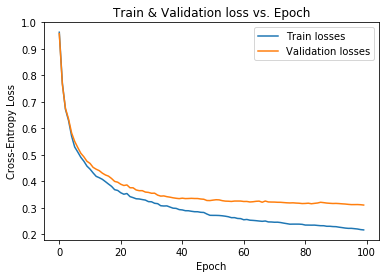

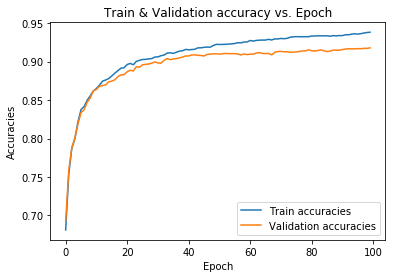

In [34]:
def partc():
  config = default_config_part_c()
  report = evaluate_model(config)
  train_report = report['train_report']
  plot_from_train_report(train_report)
partc()

In [41]:
def partreg(l2lam=0.1):
  config = custom_config_from_part_c({
    'batch_size': 256,
    'learning_rate': 0.05,
    'L2_penalty': l2lam,
    'epochs': 200,
  })
  report = evaluate_model(config)
  train_report = report['train_report']
  plot_from_train_report(train_report)

------- Model Config: 
Activation: tanh 
N Epoches: 200 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0.1 
Momentum? True
Gamma: 0.9


Epoch: 0 loss train: 0.9027564292162201 loss validate: 0.8893362086989212 Acc train: 0.70648 Acc validate: 0.708
Epoch: 1 loss train: 0.7220073689149483 loss validate: 0.7191133748032402 Acc train: 0.76782 Acc validate: 0.7677
Epoch: 2 loss train: 0.642358633114882 loss validate: 0.6483316390714675 Acc train: 0.79754 Acc validate: 0.7945
Epoch: 3 loss train: 0.5859897341323151 loss validate: 0.5918332854124306 Acc train: 0.81502 Acc validate: 0.8173
Epoch: 4 loss train: 0.5241762088752747 loss validate: 0.5367116167919113 Acc train: 0.84096 Acc validate: 0.838
Epoch: 5 loss train: 0.49341354582908564 loss validate: 0.5044346762782356 Acc train: 0.84814 Acc validate: 0.8469
Epoch: 6 loss train: 0.4729650057107506 loss validate: 0.48671679656197714 Acc train: 0.85772 Acc validate: 0.8518
Epoch: 7 loss train: 0.4484398742891398 loss validate: 0.459788984021509 Acc train: 0.86336 Acc validate: 0.8589
Epoch: 8 loss train: 0.41415762233442477 loss validate: 0.4361368281896932 Acc train: 0.87

Epoch: 71 loss train: 0.08368317990552093 loss validate: 0.1368168446201518 Acc train: 0.97654 Acc validate: 0.9603
Epoch: 72 loss train: 0.09059657318728899 loss validate: 0.1441838169799089 Acc train: 0.97546 Acc validate: 0.9566
Epoch: 73 loss train: 0.07543170099883348 loss validate: 0.12882019643312037 Acc train: 0.97934 Acc validate: 0.9614
Epoch: 74 loss train: 0.07556875722619448 loss validate: 0.12825359893220228 Acc train: 0.97994 Acc validate: 0.9632
Epoch: 75 loss train: 0.08177132489555258 loss validate: 0.13792916053307594 Acc train: 0.97794 Acc validate: 0.9589
Epoch: 76 loss train: 0.0732707009278913 loss validate: 0.12959779772812133 Acc train: 0.98028 Acc validate: 0.9604
Epoch: 77 loss train: 0.06937663052803789 loss validate: 0.12426181577039713 Acc train: 0.98136 Acc validate: 0.9628
Epoch: 78 loss train: 0.07519953549095267 loss validate: 0.13047557196976076 Acc train: 0.9804 Acc validate: 0.9611
Epoch: 79 loss train: 0.07514905005252001 loss validate: 0.130035423

Epoch: 141 loss train: 0.04649078206466454 loss validate: 0.10776095103218636 Acc train: 0.98898 Acc validate: 0.9689
Epoch: 142 loss train: 0.03770081356573327 loss validate: 0.10036870027438441 Acc train: 0.9929 Acc validate: 0.972
Epoch: 143 loss train: 0.03843941951858058 loss validate: 0.10047536989174514 Acc train: 0.99238 Acc validate: 0.9699
Epoch: 144 loss train: 0.03961837892543758 loss validate: 0.10161430053530877 Acc train: 0.99132 Acc validate: 0.9704
Epoch: 145 loss train: 0.04604461061612533 loss validate: 0.10742554346208003 Acc train: 0.9895 Acc validate: 0.968
Epoch: 146 loss train: 0.04804441145439919 loss validate: 0.11151165788834 Acc train: 0.98836 Acc validate: 0.965
Epoch: 147 loss train: 0.04497965342730543 loss validate: 0.1068476738032499 Acc train: 0.99002 Acc validate: 0.9675
Epoch: 148 loss train: 0.04458769996577885 loss validate: 0.10464410774640284 Acc train: 0.99026 Acc validate: 0.9684
Epoch: 149 loss train: 0.04140993540293805 loss validate: 0.10265

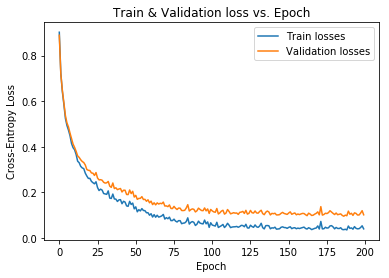

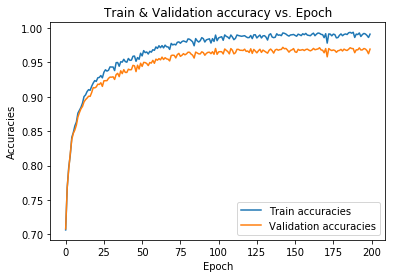

In [45]:
partreg(0.1)

------- Model Config: 
Activation: tanh 
N Epoches: 200 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0.001 
Momentum? True
Gamma: 0.9


Epoch: 0 loss train: 0.9139036939009502 loss validate: 0.9049693921927605 Acc train: 0.70196 Acc validate: 0.7087
Epoch: 1 loss train: 0.7464104525874323 loss validate: 0.7354139192408992 Acc train: 0.76022 Acc validate: 0.7647
Epoch: 2 loss train: 0.6610451447706105 loss validate: 0.6669040637155991 Acc train: 0.79196 Acc validate: 0.7893
Epoch: 3 loss train: 0.6252340197882837 loss validate: 0.6299830926698246 Acc train: 0.8016 Acc validate: 0.7984
Epoch: 4 loss train: 0.566214678531454 loss validate: 0.579075778724663 Acc train: 0.82614 Acc validate: 0.8227
Epoch: 5 loss train: 0.5288723416321177 loss validate: 0.5436611011249294 Acc train: 0.83698 Acc validate: 0.8362
Epoch: 6 loss train: 0.5003876081034102 loss validate: 0.5206930953031359 Acc train: 0.8475 Acc validate: 0.8428
Epoch: 7 loss train: 0.48656803632229123 loss validate: 0.5062310185318195 Acc train: 0.8522 Acc validate: 0.8451
Epoch: 8 loss train: 0.46674023147210325 loss validate: 0.481713180011776 Acc train: 0.85866

Epoch: 72 loss train: 0.21132411013796282 loss validate: 0.30077399233712554 Acc train: 0.93838 Acc validate: 0.9134
Epoch: 73 loss train: 0.21487419309396064 loss validate: 0.3022203690096594 Acc train: 0.93722 Acc validate: 0.9152
Epoch: 74 loss train: 0.21090550913399328 loss validate: 0.3017753528569068 Acc train: 0.9389 Acc validate: 0.9151
Epoch: 75 loss train: 0.2089476670854728 loss validate: 0.299672383493726 Acc train: 0.93912 Acc validate: 0.9148
Epoch: 76 loss train: 0.20594831450533865 loss validate: 0.30127806238888954 Acc train: 0.94076 Acc validate: 0.9138
Epoch: 77 loss train: 0.21162432413249066 loss validate: 0.3052570925011815 Acc train: 0.93836 Acc validate: 0.9137
Epoch: 78 loss train: 0.2129471519108476 loss validate: 0.3070179441840732 Acc train: 0.93816 Acc validate: 0.9119
Epoch: 79 loss train: 0.20273389957631835 loss validate: 0.3015370891590915 Acc train: 0.94214 Acc validate: 0.9148
Epoch: 80 loss train: 0.20488089636035933 loss validate: 0.300713813705128

Epoch: 143 loss train: 0.16783731993368012 loss validate: 0.29528866504797174 Acc train: 0.95346 Acc validate: 0.9193
Epoch: 144 loss train: 0.17230214498188248 loss validate: 0.3002868302846421 Acc train: 0.95048 Acc validate: 0.9162
Epoch: 145 loss train: 0.1677339750626509 loss validate: 0.2954281033257504 Acc train: 0.95312 Acc validate: 0.9212
Epoch: 146 loss train: 0.17098338815954972 loss validate: 0.29535593823312434 Acc train: 0.95172 Acc validate: 0.9195
Epoch: 147 loss train: 0.17168915503055654 loss validate: 0.299624148855278 Acc train: 0.95212 Acc validate: 0.9191
Epoch: 148 loss train: 0.1708479672070879 loss validate: 0.2973510658918725 Acc train: 0.95218 Acc validate: 0.9196
Epoch: 149 loss train: 0.1664462192300561 loss validate: 0.2943406396391686 Acc train: 0.95404 Acc validate: 0.9203
Epoch: 150 loss train: 0.16724253832412195 loss validate: 0.29625159958333763 Acc train: 0.95388 Acc validate: 0.9201
Epoch: 151 loss train: 0.16674003712388283 loss validate: 0.29503

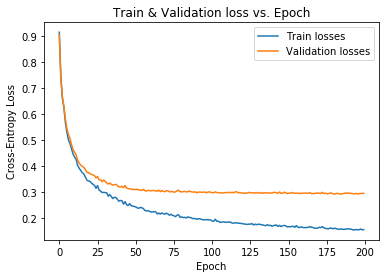

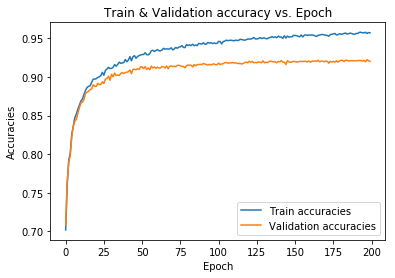

In [42]:
partreg(0.001)

------- Model Config: 
Activation: tanh 
N Epoches: 200 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 0.0001 
Momentum? True
Gamma: 0.9


Epoch: 0 loss train: 0.9106898566812696 loss validate: 0.8974121887499472 Acc train: 0.70392 Acc validate: 0.7091
Epoch: 1 loss train: 0.7449134637954468 loss validate: 0.7410383154804693 Acc train: 0.75994 Acc validate: 0.7595
Epoch: 2 loss train: 0.6599152111741988 loss validate: 0.6683126085923297 Acc train: 0.7909 Acc validate: 0.7862
Epoch: 3 loss train: 0.6157361476744441 loss validate: 0.6239336377800697 Acc train: 0.80432 Acc validate: 0.8015
Epoch: 4 loss train: 0.5586997309324945 loss validate: 0.5766419262337308 Acc train: 0.82898 Acc validate: 0.8216
Epoch: 5 loss train: 0.5308090570078118 loss validate: 0.5484367153773835 Acc train: 0.8376 Acc validate: 0.8331
Epoch: 6 loss train: 0.5012282193766454 loss validate: 0.5183538926541387 Acc train: 0.84752 Acc validate: 0.8405
Epoch: 7 loss train: 0.4933477866150897 loss validate: 0.5134653163089044 Acc train: 0.84762 Acc validate: 0.8443
Epoch: 8 loss train: 0.466423818862317 loss validate: 0.48612384791457725 Acc train: 0.858

Epoch: 72 loss train: 0.21682890660815243 loss validate: 0.3021364792867329 Acc train: 0.93694 Acc validate: 0.9128
Epoch: 73 loss train: 0.21907776811931623 loss validate: 0.3035170034911754 Acc train: 0.93574 Acc validate: 0.9146
Epoch: 74 loss train: 0.21479436442723782 loss validate: 0.3007665636656132 Acc train: 0.93624 Acc validate: 0.9119
Epoch: 75 loss train: 0.2161319198275406 loss validate: 0.30271928449426566 Acc train: 0.93658 Acc validate: 0.9129
Epoch: 76 loss train: 0.21181778784600028 loss validate: 0.2999321576606573 Acc train: 0.93888 Acc validate: 0.9129
Epoch: 77 loss train: 0.2168580404633417 loss validate: 0.30636854234897654 Acc train: 0.93574 Acc validate: 0.9118
Epoch: 78 loss train: 0.21389359126804952 loss validate: 0.306262999589695 Acc train: 0.93754 Acc validate: 0.9123
Epoch: 79 loss train: 0.21009555221487283 loss validate: 0.3029679209643882 Acc train: 0.93908 Acc validate: 0.9134
Epoch: 80 loss train: 0.20836723811368166 loss validate: 0.30005706551623

Epoch: 143 loss train: 0.17452714724656854 loss validate: 0.2986581999949054 Acc train: 0.9505 Acc validate: 0.9172
Epoch: 144 loss train: 0.17391405011042588 loss validate: 0.30019628176311186 Acc train: 0.95022 Acc validate: 0.917
Epoch: 145 loss train: 0.17352720273178307 loss validate: 0.29936070154130345 Acc train: 0.95146 Acc validate: 0.9174
Epoch: 146 loss train: 0.17810125731564783 loss validate: 0.3010491668892015 Acc train: 0.94864 Acc validate: 0.9173
Epoch: 147 loss train: 0.17783979652565143 loss validate: 0.3025863657016476 Acc train: 0.94906 Acc validate: 0.9169
Epoch: 148 loss train: 0.17312158418786375 loss validate: 0.3001762325325511 Acc train: 0.95126 Acc validate: 0.9175
Epoch: 149 loss train: 0.17301246651249189 loss validate: 0.3006482920942921 Acc train: 0.95164 Acc validate: 0.9192
Epoch: 150 loss train: 0.17130046196598855 loss validate: 0.2986374802394805 Acc train: 0.95158 Acc validate: 0.9177
Epoch: 151 loss train: 0.17348228850876898 loss validate: 0.3023

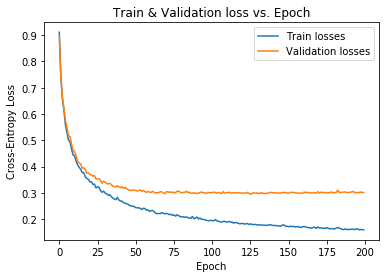

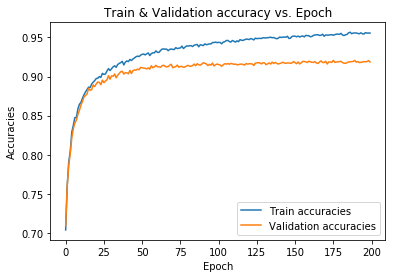

In [43]:
partreg(0.0001)

------- Model Config: 
Activation: tanh 
N Epoches: 200 
N Batches: 195 
Batch size: 256 
Learning rate: 0.05 
L2 lambda: 1 
Momentum? True
Gamma: 0.9


Epoch: 0 loss train: 0.8073895649959261 loss validate: 0.7976432395812847 Acc train: 0.73908 Acc validate: 0.7432
Epoch: 1 loss train: 0.599072549673888 loss validate: 0.6033383849633499 Acc train: 0.81678 Acc validate: 0.8164
Epoch: 2 loss train: 0.4604978890004234 loss validate: 0.46709177686322256 Acc train: 0.86634 Acc validate: 0.8655
Epoch: 3 loss train: 0.37162226869802406 loss validate: 0.38469814027775107 Acc train: 0.89596 Acc validate: 0.8914
Epoch: 4 loss train: 0.3256043349317522 loss validate: 0.33941728169667135 Acc train: 0.9083 Acc validate: 0.9041
Epoch: 5 loss train: 0.26707261609456096 loss validate: 0.2841292660686885 Acc train: 0.92592 Acc validate: 0.9206
Epoch: 6 loss train: 0.24353787300027366 loss validate: 0.2571303646159981 Acc train: 0.9339 Acc validate: 0.9329
Epoch: 7 loss train: 0.22156738983004998 loss validate: 0.23522227474844945 Acc train: 0.94074 Acc validate: 0.9358
Epoch: 8 loss train: 0.2057342736988323 loss validate: 0.2210891559898833 Acc train

Epoch: 71 loss train: 0.14399931061408752 loss validate: 0.16301882442940738 Acc train: 0.96344 Acc validate: 0.9562
Epoch: 72 loss train: 0.1527840523032105 loss validate: 0.17076380755812134 Acc train: 0.96404 Acc validate: 0.9574
Epoch: 73 loss train: 0.16397676264734812 loss validate: 0.18228546475632573 Acc train: 0.95648 Acc validate: 0.9505
Epoch: 74 loss train: 0.15945890300410145 loss validate: 0.17853012655926617 Acc train: 0.96182 Acc validate: 0.9546
Epoch: 75 loss train: 0.1778814887692195 loss validate: 0.19474697848704797 Acc train: 0.95982 Acc validate: 0.9536
Epoch: 76 loss train: 0.158807296958911 loss validate: 0.17585917409119192 Acc train: 0.9585 Acc validate: 0.9519
Epoch: 77 loss train: 0.15751529538428352 loss validate: 0.17603777232136136 Acc train: 0.95958 Acc validate: 0.9542
Epoch: 78 loss train: 0.1714288577094444 loss validate: 0.18957944453904618 Acc train: 0.95424 Acc validate: 0.9489
Epoch: 79 loss train: 0.16144398427530063 loss validate: 0.18030605608

Epoch: 142 loss train: 0.17651284393551017 loss validate: 0.1954472249608379 Acc train: 0.95422 Acc validate: 0.948
Epoch: 143 loss train: 0.17422266669719466 loss validate: 0.18957386885742744 Acc train: 0.95546 Acc validate: 0.9504
Epoch: 144 loss train: 0.15036394648378312 loss validate: 0.17057895883352686 Acc train: 0.9626 Acc validate: 0.9562
Epoch: 145 loss train: 0.1381066410490397 loss validate: 0.15679952825574928 Acc train: 0.96656 Acc validate: 0.9596
Epoch: 146 loss train: 0.16349284756988233 loss validate: 0.1792843798125633 Acc train: 0.95662 Acc validate: 0.9521
Epoch: 147 loss train: 0.1555042335520314 loss validate: 0.17759542624315064 Acc train: 0.96034 Acc validate: 0.9535
Epoch: 148 loss train: 0.1568459738001687 loss validate: 0.17609817229473831 Acc train: 0.9605 Acc validate: 0.9541
Epoch: 149 loss train: 0.1545855599786028 loss validate: 0.17419011506577972 Acc train: 0.96184 Acc validate: 0.9548
Epoch: 150 loss train: 0.14729597328897026 loss validate: 0.16497

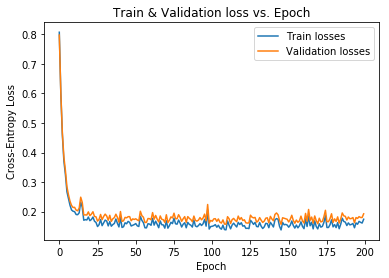

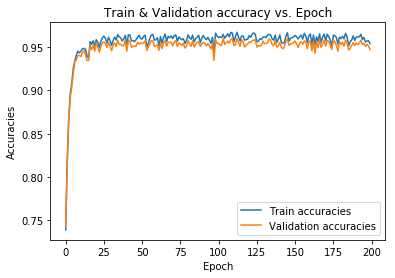

In [57]:
partreg(1)

In [9]:
def testrelu():
  config = custom_config_from_part_c({
    'activation': 'ReLU',
    'L2_penalty': 0.1,
    'learning_rate': 0.07
  })
  report = evaluate_model(config)
  train_report = report['train_report']
  plot_from_train_report(train_report)

------- Model Config: 
Activation: ReLU 
N Epoches: 100 
N Batches: 195 
Batch size: 256 
Learning rate: 0.07 
L2 lambda: 0.1 
Momentum? True
Gamma: 0.9


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:212: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:212: RuntimeWarning: invalid value encountered in multiply


Epoch: 0 loss train: 2.1373703729031464 loss validate: 2.139175379700195 Acc train: 0.17956 Acc validate: 0.1841
Epoch: 1 loss train: 2.0877559429894776 loss validate: 2.095674383798251 Acc train: 0.19166 Acc validate: 0.1938
Epoch: 2 loss train: 2.0638378149117944 loss validate: 2.0719864028401163 Acc train: 0.19848 Acc validate: 0.2012
Epoch: 3 loss train: 2.0387238058896338 loss validate: 2.0434872239568356 Acc train: 0.20406 Acc validate: 0.2077
Epoch: 4 loss train: 2.061742838821356 loss validate: 2.0759876183077433 Acc train: 0.23774 Acc validate: 0.2413
Epoch: 5 loss train: 1.790754571011738 loss validate: 1.8023578760899062 Acc train: 0.31648 Acc validate: 0.319
Epoch: 6 loss train: 1.650700494919848 loss validate: 1.661166525739172 Acc train: 0.38874 Acc validate: 0.3872
Epoch: 7 loss train: 1.537015589134924 loss validate: 1.540171971307897 Acc train: 0.42968 Acc validate: 0.4259
Epoch: 8 loss train: 1.55096364993789 loss validate: 1.5407039547188763 Acc train: 0.41464 Acc va

Epoch: 72 loss train: 0.3729555874390183 loss validate: 0.4088719309311102 Acc train: 0.89198 Acc validate: 0.8863
Epoch: 73 loss train: 0.4296479058499747 loss validate: 0.4733219062119624 Acc train: 0.87388 Acc validate: 0.8691
Epoch: 74 loss train: 0.4219379653640639 loss validate: 0.45386429887450724 Acc train: 0.87572 Acc validate: 0.8713
Epoch: 75 loss train: 0.49094697145546995 loss validate: 0.5195333454741851 Acc train: 0.85692 Acc validate: 0.853
Epoch: 76 loss train: 0.44250991279562624 loss validate: 0.4798650536026009 Acc train: 0.86926 Acc validate: 0.8633
Epoch: 77 loss train: 0.3742388693454138 loss validate: 0.4068945603132469 Acc train: 0.89092 Acc validate: 0.8857
Epoch: 78 loss train: 0.4023472492473033 loss validate: 0.43799356749804036 Acc train: 0.88036 Acc validate: 0.8733
Epoch: 79 loss train: 0.367453704704358 loss validate: 0.4077212408421789 Acc train: 0.8947 Acc validate: 0.8896
Epoch: 80 loss train: 0.4101484941101288 loss validate: 0.4403360717537271 Acc 

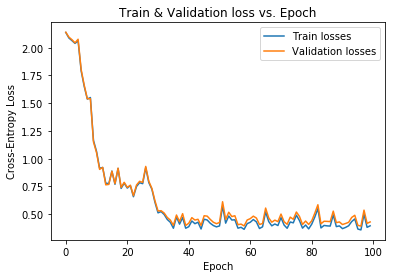

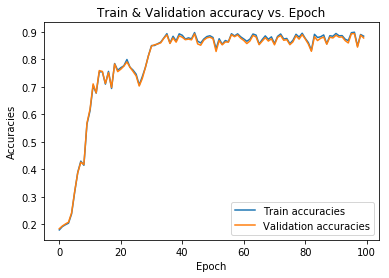

In [10]:
testrelu()